In [23]:
%load_ext autoreload
%autoreload 2
%pdb
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)

Automatic pdb calling has been turned ON


In [2]:
import sys
#sys.path.insert(0, '/home/ubuntu/Documents/infembed/infembed')
sys.path.insert(0, '/home/ubuntu/Documents/infembed/infembed')
sys.path.insert(0, '/home/ubuntu/Documents/infembed/data')
from data._core.spotcheck import get_spotcheck_dataloader, get_blindspots_df
sys.path.insert(0, '/home/ubuntu/Documents/infembed/models')
#sys.path.insert(0, '/home/ubuntu/Documents/infembed/')
# sys.path.insert(0, )
from infembed.embedder._core.fast_kfac_embedder import FastKFACEmbedder
import torchvision
from torch.utils.data import Subset, DataLoader, default_collate, Dataset
from torchvision.models import ResNet18_Weights, resnet18
import torch.nn as nn
from infembed.clusterer._core.sklearn_clusterer import SklearnClusterer
from infembed.clusterer._core.rule_clusterer import RuleClusterer
from sklearn.cluster import KMeans
from tqdm import tqdm
import pandas as pd
import torch
from typing import List
from infembed.utils.common import Data
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable
from torch import Tensor
from typing import Tuple
from models._utils.common import init_linear
from lightning.pytorch.callbacks import EarlyStopping
import lightning.pytorch as pl
import lightning as L
import torch.nn.functional as F
import numpy as np

### figure out device to compute embeddings on ###

In [3]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('device:', DEVICE)

device: cuda:0


### define data
We will define the following:
- `eval_dataset`: `Dataset` for evaluation data.  This is used to retrieve individual examples for displaying.  This should be the same data for which the embeddings we load later were computed
- `eval_dataloader`: `DataLoader` for evaluation data.  This is used to compute metadata for the evaluation data

In [4]:
normalize = ResNet18_Weights.IMAGENET1K_V1.transforms()

def collate_fn(examples):
    return tuple([_x.to(device=DEVICE) for _x in default_collate([(normalize(__x[0]), __x[1]) for __x in examples])])

BATCH_SIZE = 32
NUM_EVAL = 50000
eval_dataset = Subset(
    torchvision.datasets.ImageNet("/home/ubuntu/Documents/infembed/data/files/imagenet", split="val"),
    range(NUM_EVAL),
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)

### define model ###
only used to get metadata

In [5]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device=DEVICE)
# model.load_state_dict(ResNet18_Weights.IMAGENET1K_V1.get_state_dict(progress=True))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### load embeddings for evaluation data ###

In [6]:
# embeddings_path = '/home/ubuntu/Documents/infembed/infembed/scripts/run_embedder/outputs/imagenet_timing_experiments/0/embeddings.pt'
# embeddings_path = '/home/ubuntu/Documents/infembed/infembed/scripts/run_embedder/outputs/imagenet_kfac_global_projection_dim/1/embeddings.pt'
# embeddings_path = '/home/ubuntu/Documents/infembed/infembed/scripts/run_embedder/outputs/imagenet_kfac_last_layer/2/embeddings.pt'
# embeddings_path = '/home/ubuntu/Documents/infembed/infembed/scripts/run_embedder/outputs/imagenet_gradient_last_layer/0/embeddings.pt'
# embeddings_path = '/home/ubuntu/Documents/infembed/infembed/scripts/run_embedder/outputs/imagenet_dim_1000/0/embeddings.pt'
# embeddings_path = '/home/ubuntu/Documents/infembed/infembed/examples/imagenet/hydra_outputs/run_embeddings/imagenet_pca_gradient/4/embeddings.pt' # pca gradient 1000 dim
embeddings_path = '/home/ubuntu/Documents/infembed/infembed/examples/imagenet/hydra_outputs/run_embeddings/imagenet_arnoldi/3/embeddings.pt' # arnoldi 
embeddings = torch.load(open(embeddings_path, 'rb'))
embeddings.shape

torch.Size([50000, 195])

optionally, we can only keep some elements of the embedding (relevant for `ArnoldiEmbedder`)

In [7]:
DIMS_TO_KEEP = 50
if DIMS_TO_KEEP is not None:
    embeddings = embeddings[:, -DIMS_TO_KEEP:]

optionally, we can normalize the embeddings to have the same norm

In [8]:
NORMALIZE = False
if NORMALIZE:
    embeddings = embeddings / torch.linalg.norm(embeddings, dim=1)[:, None]

In [9]:
if True:
    # already assume embeddings fit in memory, so no point in using incremental methods
    pass

we then package them into a `Data` instance, which contains all kinds of data that could possibly be used to do the subsequent clustering, i.e. including tabular metadata as well.

In [10]:
data = Data(embeddings=embeddings)

### compute metadata for evaluation data ###
this will be the ingredient needed to display the clusters.  later on, it will also be used by the rule-based clusterer.  therefore, we also add it to the running `Data` instance for easy access.

In [14]:
def _get_predictions_and_labels(_model, dataloader):
    dfs = []
    for batch in tqdm(dataloader):
        prediction_prob = (
            torch.nn.functional.softmax(_model(*batch[:-1]), dim=1)
            .detach()
            .to(device="cpu")
        )
        prediction_label = torch.argmax(prediction_prob, dim=1).to(device="cpu")
        label = batch[-1].to(
            device="cpu"
        )  # assuming batch is a tensor.  if not, can check
        dfs.append(
            pd.DataFrame(
                {
                    "prediction_label": prediction_label,
                    "label": label,
                    "prediction_prob": list(prediction_prob.numpy()),
                }
            )
        )
    df = pd.concat(dfs, axis=0)
    df.index = list(range(len(df)))
    return df

if True:
    metadata = _get_predictions_and_labels(model, eval_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [09:42<00:00,  2.68it/s]


add in column with human-readable prediction and label names

In [15]:
import json
import pandas as pd

class_index_to_name = pd.read_csv(
    open("/home/ubuntu/Documents/infembed/data/files/imagenet/imagenet_classes.txt", "r"),
#     sep=" ",
    index_col=None,
    header=None,
    
)
class_index_to_name.columns = ['name']
class_index_to_name.index = list(range(len(class_index_to_name)))
class_index_to_name

,name
0,tench
1,goldfish
2,great white shark
3,tiger shark
4,hammerhead
...,...
995,earthstar
996,hen-of-the-woods
997,bolete
998,ear


change metadata

In [16]:
def rename(index):
    return class_index_to_name.loc[index]['name']

metadata['prediction_label_name'] = metadata['prediction_label'].apply(rename)
metadata['label_name'] = metadata['label'].apply(rename)
metadata

,prediction_label,label,prediction_prob,prediction_label_name,label_name
0,48,0,"[0.13808903, 3.4060315e-05, 0.0027270534, 0.00...",Komodo dragon,tench
1,0,0,"[0.51393855, 3.0660496e-05, 2.0497704e-05, 0.0...",tench,tench
2,391,0,"[0.030805267, 2.0275216e-05, 0.000545157, 6.36...",coho,tench
3,0,0,"[0.9989869, 6.966171e-08, 1.8682414e-07, 1.431...",tench,tench
4,0,0,"[0.99998283, 3.233246e-08, 5.418143e-10, 1.224...",tench,tench
...,...,...,...,...,...
49995,896,999,"[1.8333954e-07, 6.15772e-06, 4.712628e-06, 2.0...",washbasin,toilet tissue
49996,999,999,"[2.7936392e-07, 4.374488e-07, 1.1543527e-07, 6...",toilet tissue,toilet tissue
49997,999,999,"[1.6772799e-06, 5.0491373e-05, 9.916295e-06, 4...",toilet tissue,toilet tissue
49998,333,999,"[2.8054604e-08, 5.4920577e-07, 4.5380677e-09, ...",hamster,toilet tissue


In [17]:
data.metadata = metadata
data.dataset = eval_dataset

### define clusterer ###

In [25]:
if False:
    clusterer = SklearnClusterer(sklearn_clusterer=KMeans(n_clusters=25))
if True:
    clusterer = FAISSClusterer(k=25, spherical=True)

### do the clustering ###

In [27]:
clusters = clusterer.fit_predict(data)

### define ways to display clusters ###
these will all be functions whose input is a list of list of indices in the evaluation dataset

In [28]:
from infembed.visualization._core.common import (
    DisplayMetadata,
    DisplayPIL,
    DisplayPredictionAndLabels,
    DisplaySingleExamples,
    PerClusterDisplayer,
    DisplayAccuracy,
)

displayers = [
    PerClusterDisplayer(
        [
            DisplayAccuracy(prediction_col="prediction_label", label_col="label"),
            DisplayPredictionAndLabels(
                prediction_col="prediction_label", label_col="label"
            ),
            DisplaySingleExamples(
                [
                    DisplayMetadata(["label_name", "prediction_label_name"]),
                    DisplayPIL(),
                ],
                limit=3,
            ),
        ]
    )
]

### display the clusters ###

cluster #0
accuracy: 0.68 (34/50)
prediction: {412: 2, 41: 1, 43: 1, 47: 1, 58: 1, 59: 1, 921: 1, 113: 1, 124: 1, 132: 1, 140: 1, 186: 1, 155: 1, 194: 1, 292: 1, 335: 1, 28: 1, 353: 1, 407: 1, 452: 1, 489: 1, 494: 1, 608: 1, 532: 1, 819: 1, 575: 1, 560: 1, 589: 1, 626: 1, 818: 1, 739: 1, 672: 1, 715: 1, 718: 1, 747: 1, 645: 1, 563: 1, 806: 1, 825: 1, 838: 1, 881: 1, 850: 1, 504: 1, 929: 1, 930: 1, 976: 1, 983: 1, 984: 1, 935: 1}
label: {28: 1, 41: 1, 43: 1, 47: 1, 58: 1, 59: 1, 99: 1, 113: 1, 124: 1, 132: 1, 140: 1, 186: 1, 200: 1, 202: 1, 292: 1, 335: 1, 352: 1, 407: 1, 412: 1, 452: 1, 461: 1, 489: 1, 494: 1, 523: 1, 532: 1, 546: 1, 559: 1, 560: 1, 589: 1, 629: 1, 633: 1, 666: 1, 672: 1, 715: 1, 718: 1, 747: 1, 775: 1, 777: 1, 806: 1, 825: 1, 838: 1, 881: 1, 911: 1, 928: 1, 929: 1, 930: 1, 976: 1, 983: 1, 984: 1, 987: 1}
              label_name prediction_label_name
1404  spotted salamander    spotted salamander
     label_name prediction_label_name
2063   whiptail              whipt

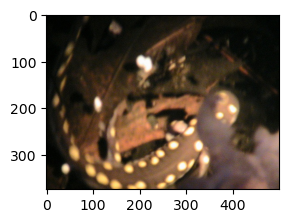

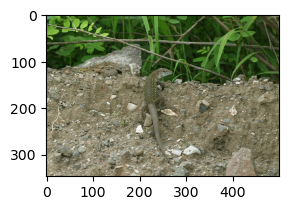

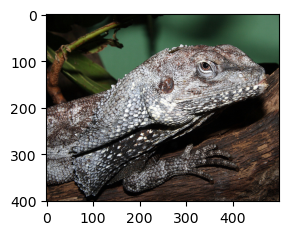

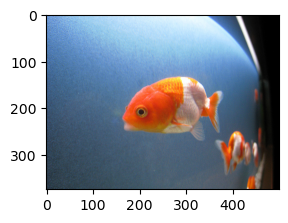

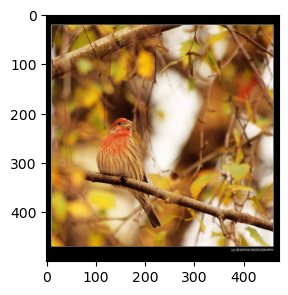

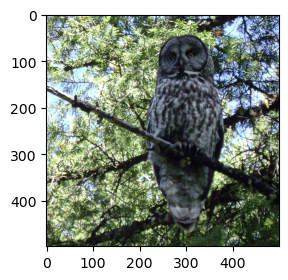

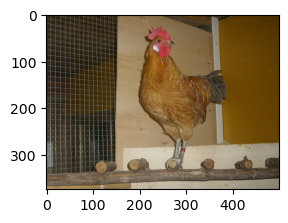

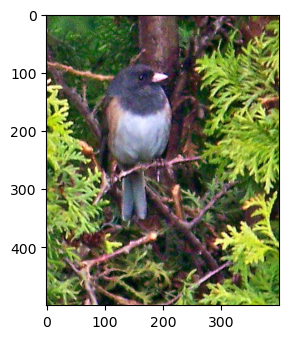

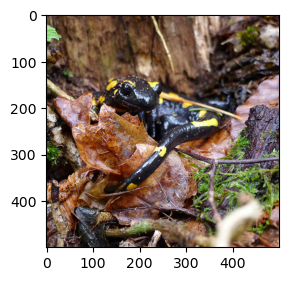

In [29]:
for displayer in displayers:
    displayer(clusters[3:6], data)

### define rule clusterer ###

In [ ]:
def _accuracy(data):
    return (data.metadata["prediction_label"] == data.metadata["label"]).mean()


def _size(data):
    return len(data)


rule_clusterer = RuleClusterer(
    clusterer_getter=lambda n_clusters: SklearnClusterer(KMeans(n_clusters=n_clusters)),
    cluster_rule=lambda data: _accuracy(data) < 0.5 and _size(data) >= 10,
    stopping_rule=lambda data: _size(data) < 50,
    max_depth=7,
    branching_factor=3,
)

### do the rule clustering ###

In [ ]:
rule_clusters = rule_clusterer.fit_predict(data)

### display the rule clusters

cluster #0
accuracy: 0.40 (4/10)
prediction: {185: 2, 19: 1, 201: 1, 151: 1, 230: 1, 364: 1, 780: 1, 692: 1, 321: 1}
label: {12: 1, 154: 1, 158: 1, 185: 1, 191: 1, 230: 1, 364: 1, 780: 1, 921: 1, 946: 1}
      label_name prediction_label_name
632  house finch             chickadee
     label_name prediction_label_name
7742   Pekinese         silky terrier
       label_name prediction_label_name
7919  toy terrier             Chihuahua


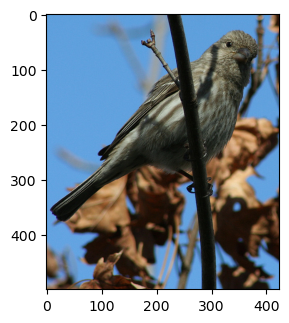

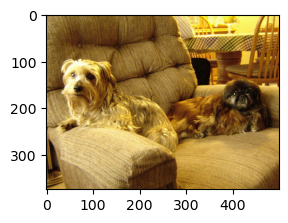

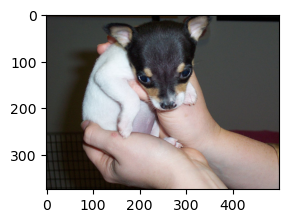

In [ ]:
for displayer in displayers:
    displayer(rule_clusters, data)